# Find affine transformation for registering sMRI to dMRI using DiPy

BMED360-2021  `02-dmri-find-affine-fs-brainmask2dwi.ipynb`

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/02-dmri-find-affine-fs-brainmask2dwi.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives

- Affine 3D registration between a 3D brain mask in native T1 space and a 3D mean S0 image in native DWI space 
- Using Multilevel optimization and the Mutual Information similarity measure as implemented in DiPy (ANTS

See: https://dipy.org/documentation/1.0.0./examples_built/affine_registration_3d

### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown

In [2]:
#!pip install nilearn

In [3]:
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [4]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [5]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [6]:
cwd = os.getcwd()

In [7]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [8]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [9]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


# Image registration using dipy

See also https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html

DIPY is a free and open source software project for computational neuroanatomy, focusing mainly on diffusion magnetic resonance imaging (dMRI) analysis. It implements a broad range of algorithms for denoising, registration, reconstruction, tracking, clustering, visualization, and statistical analysis of MRI data.

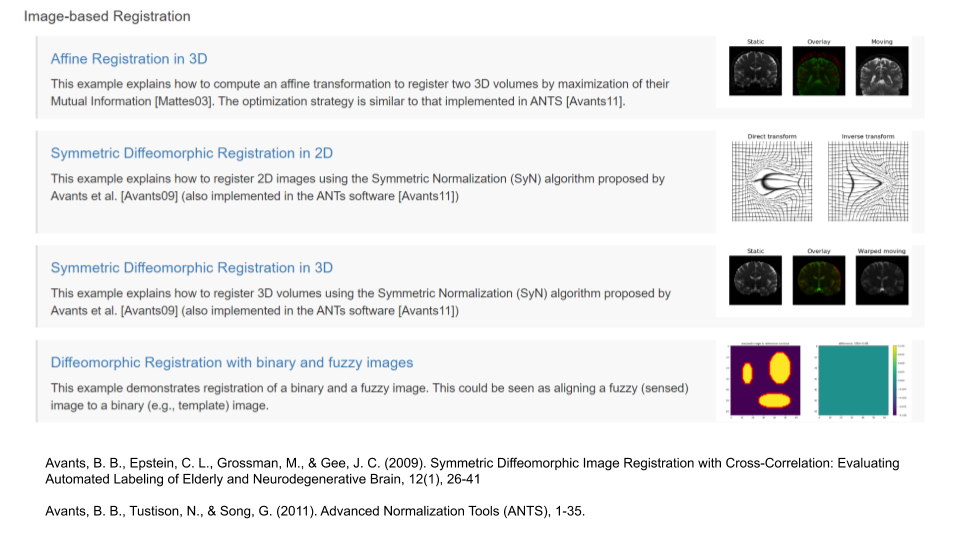

In [10]:
from IPython.display import Image
Image("assets/dipy_image_registration_ants.png")

### Install

How to install [dipy](https://dipy.org)

 * https://dipy.org/documentation/1.0.0./installation

### Usage

https://dipy.org/tutorials  (see also https://carpentries-incubator.github.io/SDC-BIDS-dMRI/aio/index.html)

## Make an affine registration function `affine_anat2dwi`

In [11]:
import os
import pathlib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
# home = expanduser('~') # To make path to local home directory
import time
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap, MutualInformationMetric, AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from dipy.io.image import save_nifti

/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/dipy/viz/__init__.py:31: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  warnings.warn(


In [12]:
def affine_anat2dwi(inpdir, sub, ses, outdir):
    r"""
    Affine registration between a 3D T1w brain mask and a mean S0 in native DWI space using multilevel optimization and the 
    Mutual Information similarity measure.
    
    Brain extraction of a 3D T1w recording (assuming BIDS) has been performed using Freesurfer recon-all 
    general pipeline for processing anatomical (3D T1w) images, including brain-extraction, tissue segmentation, 
    and subcortical structure segmentation. The Freesurfer pipeline is implemented in 
    'freesurfer-segmentation-bash.ipynb'.
    
    The static target image '...dwi_S0_mean.nii.gz' is obtained from '01-dmri-extract-S0s.ipynb'

    Parameters
    ----------
    inpdir     : input directory e.g. inpdir = './data/dmri_results' where the moving file, e.g.
                  join(inpdir, 'sub_%d_tp%d_brainmask_in_native_space.nii.gz' % (sub, ses)), and 
                  the static file, e.g.
                  join(inpdir, 'sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses)) lives [cf. 01-dmri-extract-S0s.ipynb]
                  and the follwing file will be derived and stored
                  join(inpdir, 'sub_%d_tp%d_brainmask_bin_in_native_space.nii.gz' % (sub, ses))
    sub        : subject id, e.g. 102 for sub-102
    ses        : session number, eg 1 for ses-1
    outdir     : output directory e.g. outdir = inpdir, where resulting affine matrix and transformed input moving image are stored, e.g.
                  np.savetxt(affine_fn, affine.get_affine(), delimiter=',')   and
                  moving2static = nib.Nifti1Image(transformed, static_affine)
                  nib.save(moving2static, transformed_fn)  and
                  moving2static_mask = nib.Nifti1Image(transformed_mask, static_affine)
                  nib.save(moving2static_mask, transformed_mask_fn)

    Returns
    -------
    moving_data, moving_affine, moving_mask_data, moving_mask_affine, static_data, static_affine, transformed, 
    transformed_mask, affine, outp_affine_fn


    Notes
    -----
    
    To save affine:
        np.savetxt(outp_affine_fn, affine.get_affine(), delimiter=',')  
    To load:  
        aff = np.loadtxt(outp_affine_fn, delimiter=',')
        affine_map = AffineMap(np.eye(4))
        affine_map.set_affine(aff)
    
    AffineMap:

    Implements an affine transformation whose domain is given by
    `domain_grid` and `domain_grid2world`, and whose co-domain is
    given by `codomain_grid` and `codomain_grid2world`.

    The actual transform is represented by the `affine` matrix, which
    operate in world coordinates. Therefore, to transform a moving image
    towards a static image, we first map each voxel (i,j,k) of the static
    image to world coordinates (x,y,z) by applying `domain_grid2world`.
    Then we apply the `affine` transform to (x,y,z) obtaining (x', y', z')
    in moving image's world coordinates. Finally, (x', y', z') is mapped
    to voxel coordinates (i', j', k') in the moving image by multiplying
    (x', y', z') by the inverse of `codomain_grid2world`. The
    `codomain_grid_shape` is used analogously to transform the static
    image towards the moving image when calling `transform_inverse`.

    If the domain/co-domain information is not provided (None) then the
    sampling information needs to be specified each time the `transform`
    or `transform_inverse` is called to transform images. Note that such
    sampling information is not necessary to transform points defined in
    physical space, such as stream lines.
    Returns the value of the transformation.
    
    
    MutualInformationMetric: 
    
    Computes the value and gradient of the mutual information metric the way `Optimizer` needs them. 
    That is, given a set of transform parameters, it will use `ParzenJointHistogram`
    to compute the value and gradient of the joint intensity histogram
    evaluated at the given parameters, and evaluate the the value and
    gradient of the histogram's mutual information.
    
    
    AffineRegistration: 
    
    Runs the multi-resolution registration, putting all the pieces together. 
    It needs to create the scale space of the images and run the multi-resolution 
    registration by using the Metric and the Optimizer at each level of the Gaussian pyramid. 
    At each level, it will setup the metric to compute value and gradient of the
    metric with the input images with different levels of smoothing.

    """
    
    # Preparations
    
    moving_fn = join(inpdir, 'sub_%d_tp%d_brainmask_in_native_space.nii.gz' % (sub, ses))
    
    ## Make binary brainmask
    bmask_bin_fn = join(inpdir, 'sub_%d_tp%d_brainmask_bin_in_native_space.nii.gz' % (sub, ses))
    bmask = nib.load(moving_fn)
    bmask_data = bmask.get_fdata()
    f = bmask_data.flatten()
    f[np.where(f > 0)] = 1 
    bmask_bin_data = f.reshape(bmask_data.shape)
    bmask_bin = nib.Nifti1Image(bmask_bin_data, bmask.affine)
    nib.save(bmask_bin, bmask_bin_fn)
    
    
    moving_mask_fn = bmask_bin_fn
    static_fn = join(inpdir, 'sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses))

    outp_affine_fn = join(outdir, 'sub_%d_tp%d_affine_brainmask_to_dwi_S0_mean.mat' % (sub, ses))
    transformed_fn = join(outdir, 'sub_%d_tp%d_brainmask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    transformed_mask_fn = join(outdir, 'sub_%d_tp%d_brainmask_bin_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    
    
    moving_img = nib.load(moving_fn)
    moving_mask = nib.load(moving_mask_fn)
    static_img = nib.load(static_fn)
 
    moving_data = moving_img.get_fdata()
    moving_affine = moving_img.affine
    moving_mask_data = moving_mask.get_fdata()
    moving_mask_affine = moving_mask.affine
    static_data = static_img.get_fdata()
    static_affine = static_img.affine


    
    affine_map = AffineMap(affine=np.eye(4),    # identity
                       domain_grid_shape=static_data.shape, 
                       domain_grid2world=static_affine,
                       codomain_grid_shape=moving_data.shape, 
                       codomain_grid2world=moving_affine)
    
    resampled = affine_map.transform(moving_data)

    
    # The similarity (mismatch) metric
    #  - this class implements the methods required by Optimizer to drive the registration process

    nbins = 32 # the number of bins to be used for computing the intensity histograms
    sampling_prop = None   # sampling_proportion (dense = None, or sparse (prop in [0,1]))
    metric = MutualInformationMetric(nbins, sampling_prop)
    
    # The optimization strategy

    level_iters = [10, 10, 5]
    sigmas = [3.0, 1.0, 0.0]
    factors = [4, 2, 1]  # scale factors to build the scale space (one factor for each scale)
    
    # We set up the registration object, ready to do the registration

    affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors,
                            method='L-BFGS-B', # or CG, BFGS, Newton-CG, dogleg, trust-ncg
                            ss_sigma_factor=None,
                            options=None,
                            verbosity=0)  # 0: do not print anything, 3: print maximum
    
    
    # - First we optimize the translations. We do the translations first to get an approximation 
    # - After that we will estimate translations and rotations together, 
    #    using the estimated translations as a starting point. 
    # - Last we will use the translations and rotations as a starting point for a 
    #    full affine registration.

    transform_translation = TranslationTransform3D()

    translation = affreg.optimize(
        static=static_data, 
        moving=moving_data, 
        transform=transform_translation, # with respect to whose parameters the gradient must be computed
        params0 = None,
        static_grid2world=static_affine, 
        moving_grid2world=moving_affine,
        starting_affine=None, # 'mass': align centers of gravity, 'voxel-origin', 'centers'
        ret_metric=False # returns the parameters of the similarity between the images
    )
    
    # We now have our estimated translations: translation.affine
    
    
    # Next we use the estimated translations as a starting point to optimize a rigid-body transform. 
    # A rigid-body transform is a transform that does not change the shape of the object. 
    # It allows only translations and rotations.

    transform_rigid = RigidTransform3D()
    
    rigid = affreg.optimize(
        static=static_data, 
        moving=moving_data, 
        transform=transform_rigid, # with respect to whose parameters the gradient must be computed
        params0 = None,
        static_grid2world=static_affine, 
        moving_grid2world=moving_affine,
        starting_affine=translation.affine, #  or'mass': align centers of gravity, 'voxel-origin', 'centers'
        ret_metric=False # returns the parameters of the similarity between the images
    )
    
    
    # Last, we do a full affine registration, using the rigid body estimate as a starting point.

    transform_affine = AffineTransform3D()
    
    # Increase the number of iterations to get an more exact fit
    affreg.level_iters = [1000, 1000, 100]

    
    affine = affreg.optimize(
        static=static_data, 
        moving=moving_data, 
        transform=transform_affine, # with respect to whose parameters the gradient must be computed
        params0 = None,
        static_grid2world=static_affine, 
        moving_grid2world=moving_affine,
        starting_affine=rigid.affine, #  or'mass': align centers of gravity, 'voxel-origin', 'centers'
        ret_metric=False # returns the parameters of the similarity between the images
    )

    transformed = affine.transform(
        image=moving_data,
        interpolation='linear', # 'linear' (k-linear interpoltaion) or 'nearest'
        image_grid2world=None,
        sampling_grid_shape=None,
        sampling_grid2world=None,
        resample_only=False
    )
    
    transformed_mask = affine.transform(
        image=moving_mask_data,
        interpolation='nearest', # 'linear' (k-linear interpoltaion) or 'nearest'
        image_grid2world=None,
        sampling_grid_shape=None,
        sampling_grid2world=None,
        resample_only=False
    )
    
    # Saving and returning results
    
    np.savetxt(outp_affine_fn, affine.get_affine(), delimiter=',')  
    # To laod:  aff = np.loadtxt(outp_affine_fn, delimiter=',')
    #           affine_map = AffineMap(np.eye(4))
    #           affine_map.set_affine(aff)
    
    moving2static = nib.Nifti1Image(transformed, static_affine)
    nib.save(moving2static, transformed_fn)
    
    moving2static_mask = nib.Nifti1Image(transformed_mask, static_affine)
    nib.save(moving2static_mask, transformed_mask_fn)
    
    return moving_data, moving_affine, moving_mask_data, moving_mask_affine, static_data, static_affine, \
        transformed, transformed_mask, affine, outp_affine_fn



### Test the function
Require the files `sub_102_tp1_brainmask_in_native_space.nii.gz` and the one being calculated and saved `sub_102_tp1_brainmask_bin_in_native_space.nii.gz` obtained from running the Freesurfer and np.where()

In [13]:
#help(affine_anat2dwi)

In [14]:
inp_dir = dmri_res
outp_dir = inp_dir
sub = 102
ses = 1

In [15]:
%%time
moving_data, moving_affine, moving_mask_data, moving_mask_affine, static_data, static_affine, \
transformed, transformed_mask, affine, outp_affine_fn = \
affine_anat2dwi(inp_dir, sub, ses, outp_dir)

CPU times: user 2min 1s, sys: 2.57 s, total: 2min 4s
Wall time: 43.2 s


In [16]:
print(f"sub_{sub}_tp{ses}")
print(f"moving_data.shape: {moving_data.shape}")
print(f"static_data.shape: {static_data.shape}")
print(f"transformed.shape: {transformed.shape}")
print(f"transformed_mask.shape: {transformed_mask.shape}")
print(f"moving_affine:\n {moving_affine}")
print(f"moving_mask_affine:\n {moving_mask_affine}")
print(f"static_affine:\n {static_affine}")
print(f"affine:\n {affine}")

sub_102_tp1
moving_data.shape: (188, 256, 256)
static_data.shape: (128, 128, 50)
transformed.shape: (128, 128, 50)
transformed_mask.shape: (128, 128, 50)
moving_affine:
 [[-9.99601960e-01  1.09721320e-02  2.64692828e-02  8.93262405e+01]
 [ 1.08074788e-02  1.01554072e+00 -2.78941705e-04 -1.08258850e+02]
 [ 2.60588042e-02 -0.00000000e+00  1.01525497e+00 -1.18557945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
moving_mask_affine:
 [[-9.99601960e-01  1.09721320e-02  2.64692828e-02  8.93262405e+01]
 [ 1.08074788e-02  1.01554072e+00 -2.78941705e-04 -1.08258850e+02]
 [ 2.60588042e-02 -0.00000000e+00  1.01525497e+00 -1.18557945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
static_affine:
 [[-1.71879995e+00 -1.04905921e-03  5.71428565e-04  1.13637230e+02]
 [-9.96618648e-04  1.71841156e+00  5.10816313e-02 -8.59372635e+01]
 [ 4.19629563e-04 -3.65607664e-02  2.39945722e+00 -9.88118267e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.0

In [17]:
# To load affine map:  
aff = np.loadtxt(outp_affine_fn, delimiter=',')
affine_map = AffineMap(np.eye(4))
affine_map.set_affine(aff)
affine_map

array([[ 9.93329062e-01,  2.15389968e-03, -1.53516408e-03,
        -3.16074307e-01],
       [-8.34732402e-03,  9.95466039e-01, -2.20671926e-02,
         2.29628669e+00],
       [-3.23092895e-03, -1.59333764e-02,  9.94291096e-01,
        -8.09377591e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [18]:
 ## Save moving and static and registered images to disk
    
moving_copied_fn = join(outp_dir, 'TEST_AFFINE_ANAT2DWI_sub_%d_tp%d_brainmask_in_native_space.nii.gz' % (sub, ses))
static_copied_fn = join(outp_dir, 'TEST_AFFINE_ANAT2DWI_sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses))
moving2static_aff_fn = join(outp_dir, 'TEST_AFFINE_ANAT2DWI_sub_%d_tp%d_brainmask_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
moving2static_mask_aff_fn = join(outp_dir, 'TEST_AFFINE_ANAT2DWI_sub_%d_tp%d_brainmask_bin_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))

    
moving_copied = nib.Nifti1Image(moving_data, moving_affine)
#nib.save(moving_copied, moving_copied_fn)

static_copied = nib.Nifti1Image(static_data, static_affine)
#nib.save(static_copied, static_copied_fn)

moving2static = nib.Nifti1Image(transformed, static_affine)
#nib.save(moving2static, moving2static_aff_fn)

moving2static_mask = nib.Nifti1Image(transformed_mask, static_affine)
#nib.save(moving2static_mask, moving2static_mask_aff_fn)

### regtools

Plot three overlaid slices from the given volumes.

```python
regtools.overlay_slices(
    L,
    R,
    slice_index=None,
    slice_type=1,
    ltitle='Left',
    rtitle='Right',
    fname=None,
    **fig_kwargs,
)
```

Creates a figure containing three images: the gray scale k-th slice of
the first volume (L) to the left, where k=slice_index, the k-th slice of
the second volume (R) to the right and **the k-th slices of the two given
images on top of each other using the red channel for the first volume and
the green channel for the second one**. It is assumed that both volumes have
the same shape. The intended use of this function is to visually assess the
quality of a registration result.

**Parameters:**

```
L : array, shape (S, R, C)
    the first volume to extract the slice from plotted to the left
R : array, shape (S, R, C)
    the second volume to extract the slice from, plotted to the right
slice_index : int (optional)
    the index of the slices (along the axis given by slice_type) to be
    overlaid. If None, the slice along the specified axis is used
slice_type : int (optional)
    the type of slice to be extracted:
    0=sagital, 1=coronal (default), 2=axial.
ltitle : string (optional)
    the string to be written as the title of the left image. By default,
    no title is displayed.
rtitle : string (optional)
    the string to be written as the title of the right image. By default,
    no title is displayed.
fname : string (optional)
    the name of the file to write the image to. If None (default), the
    figure is not saved to disk.
fig_kwargs: extra parameters for saving figure, e.g. `dpi=300`.
```


See alse example on **Registration** here: https://neurohackweek.github.io/image-processing/04-registration/

In [19]:
#regtools.overlay_slices??

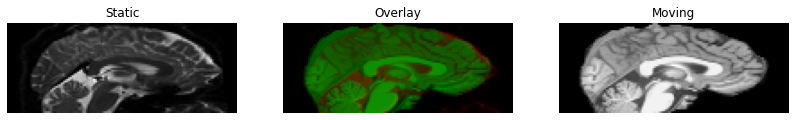

In [20]:
fig = regtools.overlay_slices(static_data, transformed, None, 0, "Static", "Moving").set_size_inches(14,10)

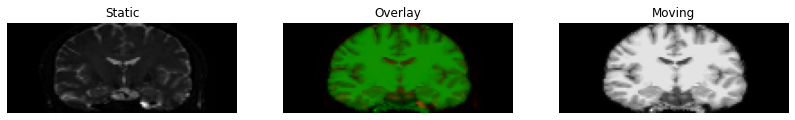

In [21]:
regtools.overlay_slices(static_data, transformed, None, 1, "Static", "Moving").set_size_inches(14,10)

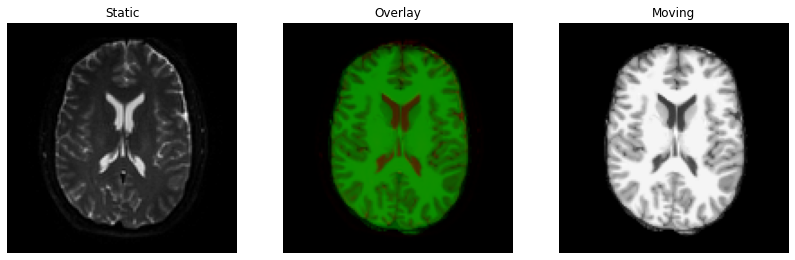

In [22]:
regtools.overlay_slices(static_data, transformed, None, 2, "Static", "Moving").set_size_inches(14,10)

## Run for all subjects

In [23]:
inp_dir = dmri_res
outp_dir = inp_dir

In [24]:
%%time
for sub in [102, 103, 111, 123]:
    for ses in [1]:
        
        print(f'Computing sub:{sub} ses:{ses}')
    
        moving_data, moving_affine, moving_mask_data, moving_mask_affine, static_data, static_affine, \
        transformed, transformed_mask, affine, outp_affine_fn = affine_anat2dwi(inp_dir, sub, ses, outp_dir)


Computing sub:102 ses:1
Computing sub:103 ses:1
Computing sub:111 ses:1
Computing sub:123 ses:1
CPU times: user 9min 6s, sys: 11.6 s, total: 9min 18s
Wall time: 3min 24s


#  OPTIONAL: 

### Preprocessing with the `fsl_anat` - Anatomical Processing Script from FSL (Linux/MacOS)
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/fsl_anat


Here we assume the `fsl_anat` anatomical processing script has produced the following files:<br>
`sub_101_tp1_T1_biascorr_brain.nii.gz` and `sub_101_tp1_T1_biascorr_brain_mask.nii.gz` and these are copied to the `./data/dmri_analysis` directory.

This FSL tool (`fsl_anat`) provides a general pipeline for processing anatomical images (e.g. T1-weighted scans).

Most of the pipeline involves standard use of FSL tools, but the bias-field correction has been substantially improved, especially for strong bias-fields typical of multi-coil arrays and high-field scanners.

The stages in the pipeline (in order) are:

- reorient the images to the standard (MNI) orientation [fslreorient2std]

- automatically crop the image [robustfov]

- bias-field correction (RF/B1-inhomogeneity-correction) [FAST]

- registration to standard space (linear and non-linear) [FLIRT and FNIRT]

- brain-extraction [FNIRT-based or BET]

- tissue-type segmentation [FAST]

- subcortical structure segmentation [FIRST]

The overall run-time is heavily dependent on the resolution of the image but anything between 30 and 90 minutes would be typical.

```python
# On Linux workstations, typically:
FSLANAT = '/usr/local/fsl/bin/fsl_anat'
#print(os.popen(FSLANAT).read())
```

```python
def bg_fsl_anat(inpdir, fsl_anat_dir, subj):
    for i, s in enumerate(subj):

        my_directory = '%s/%s' % (inpdir, s)
        
        print('Running batch exam #', i+1, ':', my_directory)
        
        T1_files = []
        T1_names = []
        for file_path in Path(inpdir).glob('%s/**/*ses-*_T1w.nii.gz' % s):
            T1_files.append(str(file_path))
            T1_names.append(str(file_path.name[:-11])) # truncate end of filename:  _T1w.nii.gz
        all_T1_files = sorted(T1_files)   
        all_T1_names = sorted(T1_names)
        print('\n', all_T1_files)
        print(all_T1_names,'\n')
        
        for k, ss in enumerate(all_T1_names):
            struct_image = all_T1_files[k]
            print(struct_image)
         
            output_dir = '%s/%s' % (fsl_anat_dir, ss)
            output_log = '%s/%s_output.log' % (fsl_anat_dir, ss)
            error_output_log = '%s/%s_error_output.log' % (fsl_anat_dir, ss)
    
            cmd = [
                FSLANAT,
                '--clobber',
                '-t', 'T1',
                '-i', struct_image, 
                '-o', output_dir,
                ' 2>', error_output_log,'>', output_log, '&']
            cmd_str = " ".join(cmd)
            print('%s\n' % cmd_str)
            os.system(cmd_str)
```

```python
# Testing:
subjs = [
'sub-102',
]

bg_fsl_anat(inpdir, fsl_anat_dir, subjs)
```